# Homework 2 

## General block 

In [100]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
setX = pd.read_excel("X_4_16.xlsx", engine='openpyxl')
setY = pd.read_excel("Y_4_16.xlsx", engine='openpyxl')

### Choisen distance = Manhhaten

In [102]:
def getDistMatrix(dataset):
    matrix_condensed = scipy.spatial.distance.pdist(dataset, metric='cityblock')
    dist_matrix = scipy.spatial.distance.squareform(matrix_condensed)

    return dist_matrix, matrix_condensed

dist_matirx_X, dist_matrix_X_condenced = getDistMatrix(setX)


### Similarity matrices

In [103]:
def getSimilarityMatrix(dist_matrix):
    median = np.median(dist_matrix[dist_matrix > 0])
    betta = 1 / median
    sim_matrix = np.exp(-betta * dist_matrix)
    np.fill_diagonal(sim_matrix, 0)

    return sim_matrix

similar_matrix_X = getSimilarityMatrix(dist_matirx_X)


### Graph model + visualization (Алгоритм принудительного размещения (Force-Directed Layout), а именно его реализацию, известную как Fruchterman-Reingold (FR) Layout.)

+ добавить визуализацию при помощи PCA?


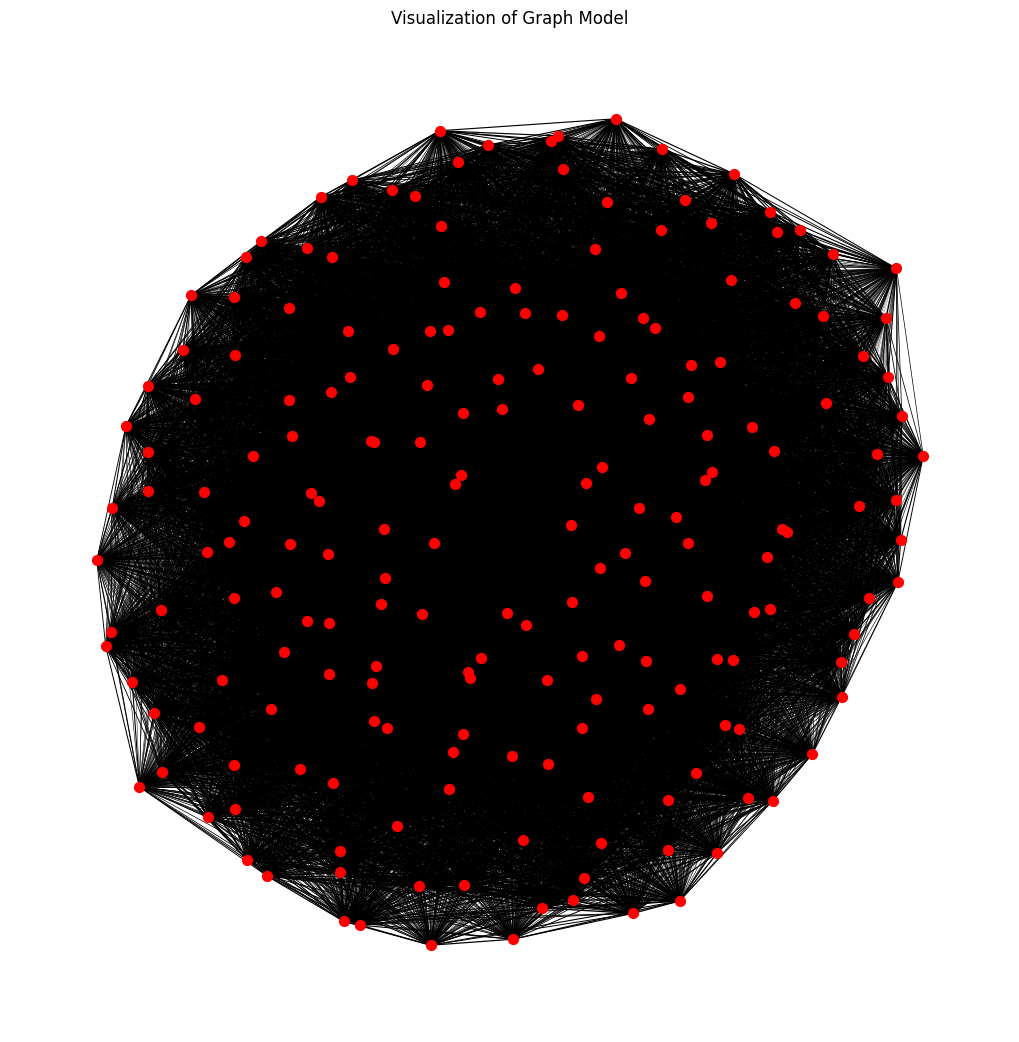

In [104]:
def plotGraph(G_full):
    pos = nx.spring_layout(G_full)

    edges = G_full.edges()
    weights = [G_full[u][v]['weight'] * 1 for u, v in edges] 

    plt.figure(figsize=(10, 10))
    nx.draw(
        G_full,
        pos,
        edge_color='black', 
        width=weights,     
        with_labels=False,  
        node_color='red',
        node_size=50
    )
    plt.title(f"Visualization of Graph Model")
    plt.show()

G_full = nx.from_numpy_array(similar_matrix_X)

GraphModel = plotGraph(G_full)

##  how can we simplify this graph?

### theshold method

+ связность графа не сохраняется, нужен иной метод

In [105]:
def theshold_method(similar_matrix, tau_in=0.8):
    tau = tau_in

    A = similar_matrix.copy()
    A[A < tau] = 0

    G_A = nx.from_numpy_array(A)


    GraphModel = plotGraph(G_A)

    return GraphModel

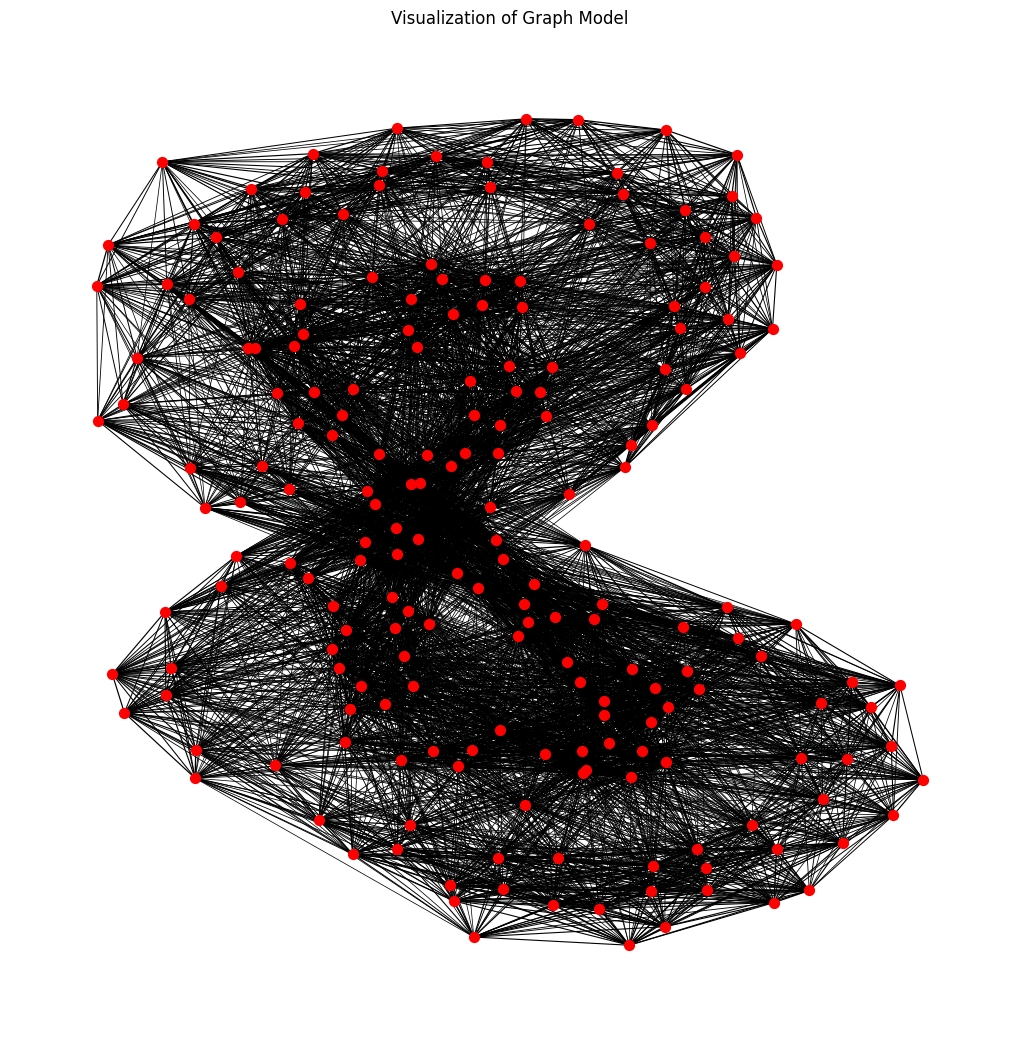

In [106]:
Thes_GM = theshold_method(similar_matrix_X, 0.5)

### MST method

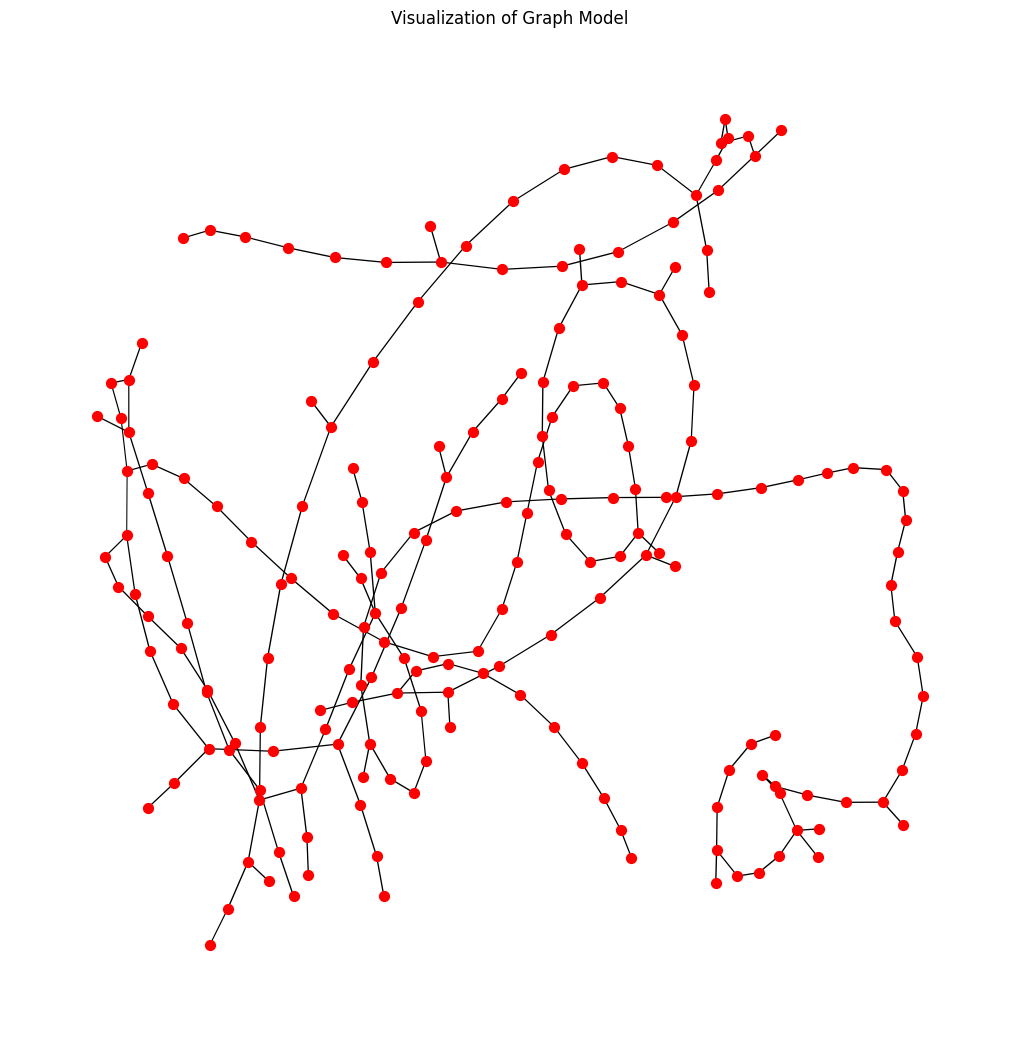

Graph with 199 nodes and 198 edges


In [107]:
def MST_method(similar_matrix):
    mst = nx.maximum_spanning_tree(nx.from_numpy_array(similar_matrix))
    plotGraph(mst)

    return mst

MST_G = MST_method(similar_matrix_X)
print(MST_G)

### PCA for visualization

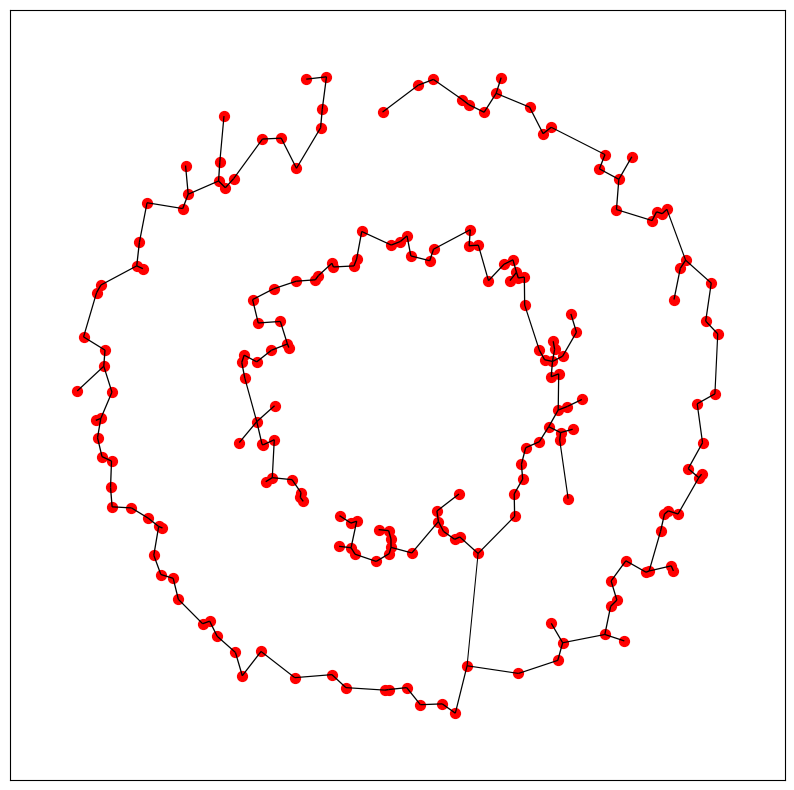

In [108]:
def PCA_(data, G_mast, clusters = None):
    data_scaled = StandardScaler().fit_transform(data)

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data_scaled)
    pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])

    pos_pca = {i: principal_components[i, :] for i in range(len(pca_df))}

    plt.figure(figsize=(10, 10))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], c = clusters, s=50) # Точки

    edges_mast = G_mast.edges(data=True)
    weights_mast = [d['weight'] * 1 for u, v, d in edges_mast] # Используем те же веса для рёбер

    nx.draw_networkx_edges(
        G_mast,
        pos=pos_pca, 
        edge_color='black',
        width=weights_mast,
        alpha=1,
    )
    
    plt.show()


PCA_(setX, MST_G, clusters='red')

## 2-clusters

+ используем ward linkage

In [109]:
Z_X = linkage(dist_matrix_X_condenced, method='ward')

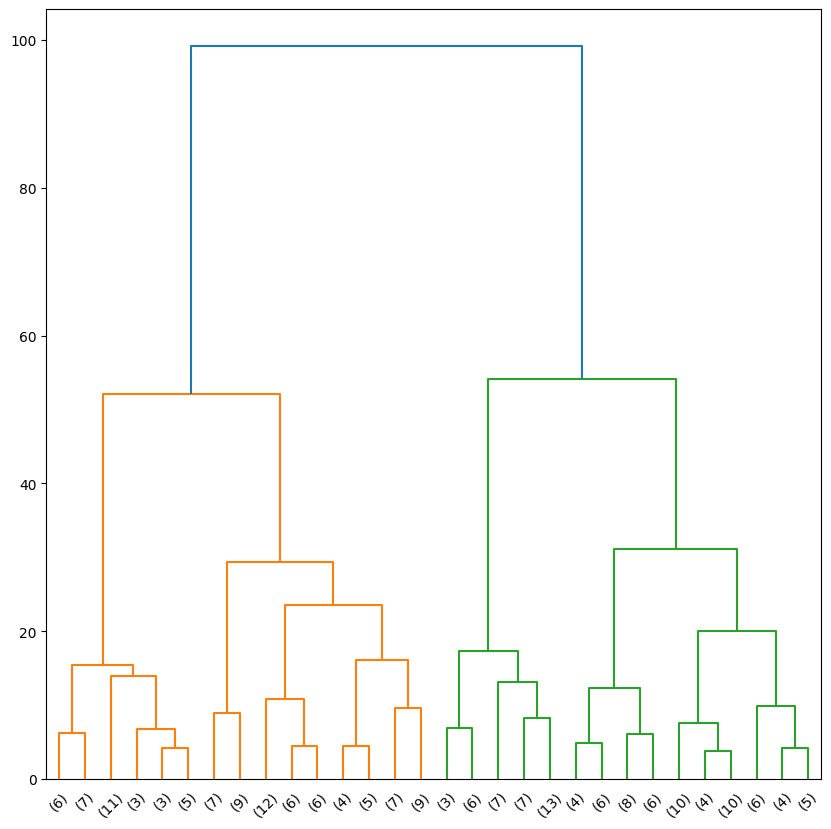

In [110]:
# dendogram
plt.figure(figsize=(10, 10))

dn = dendrogram(
    Z_X,
    truncate_mode='lastp',
    p=30,
    show_leaf_counts=True
)

plt.show()

In [111]:
cluster_labels_X_ward = fcluster(Z_X, t=60, criterion='distance')

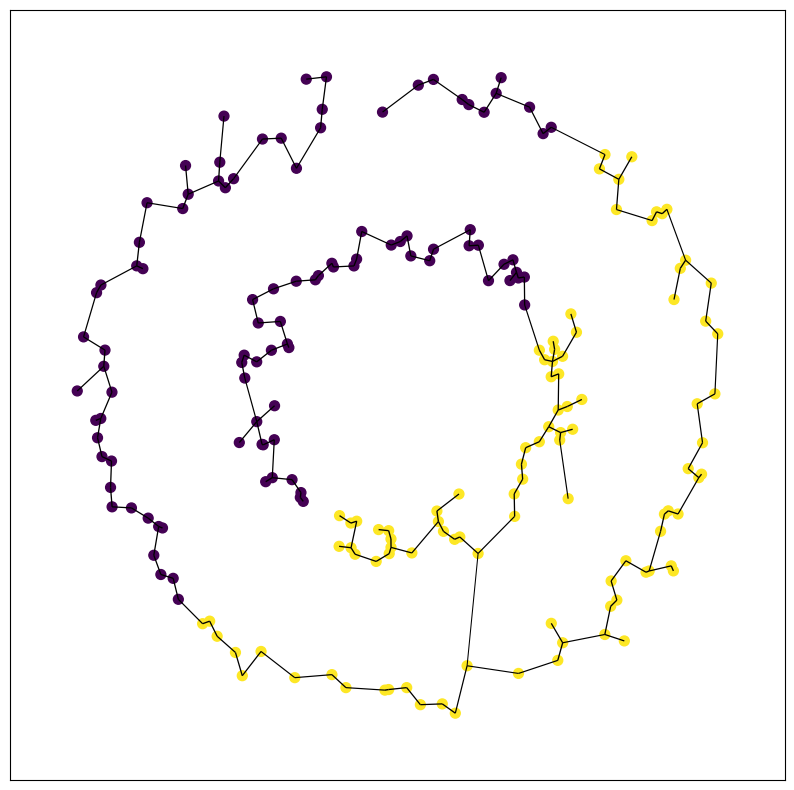

In [112]:
PCA_(setX, MST_G, cluster_labels_X_ward)

### k-means


In [113]:
k_means = KMeans(n_clusters=2, random_state=42, n_init='auto')

In [114]:
data_scaled_X = StandardScaler().fit_transform(setX)

In [115]:
cluster_labels_X_kmeans = k_means.fit_predict(data_scaled_X)

In [116]:
print(cluster_labels_X_kmeans)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


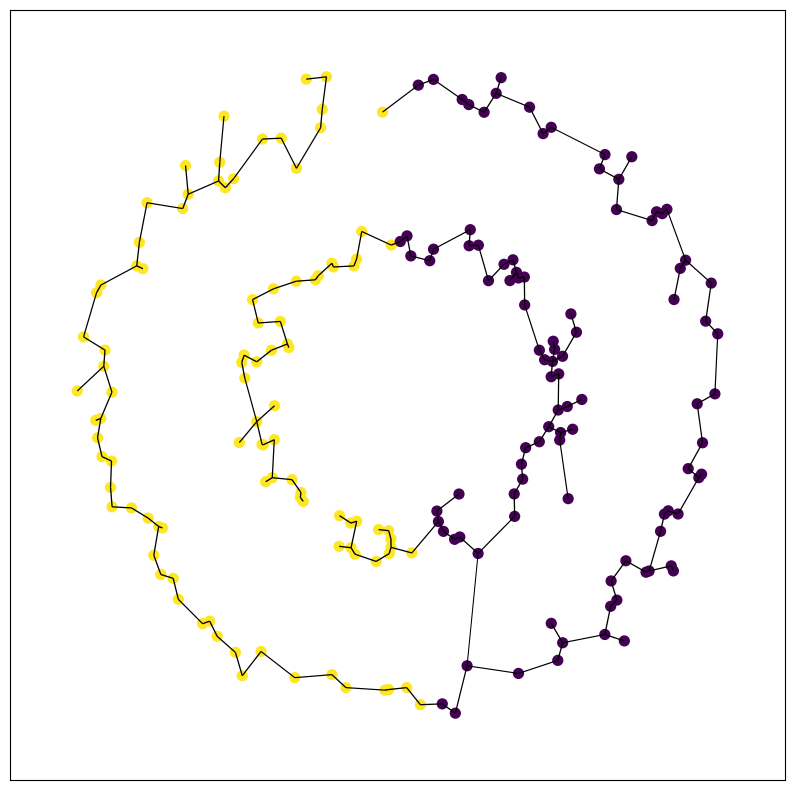

In [117]:
PCA_(setX, MST_G, cluster_labels_X_kmeans)

## EM algorithm

In [118]:
gauss_mix = GaussianMixture(n_components=2, random_state=42, n_init=10)

In [119]:
cluster_labels_X_EM = gauss_mix.fit_predict(data_scaled_X)

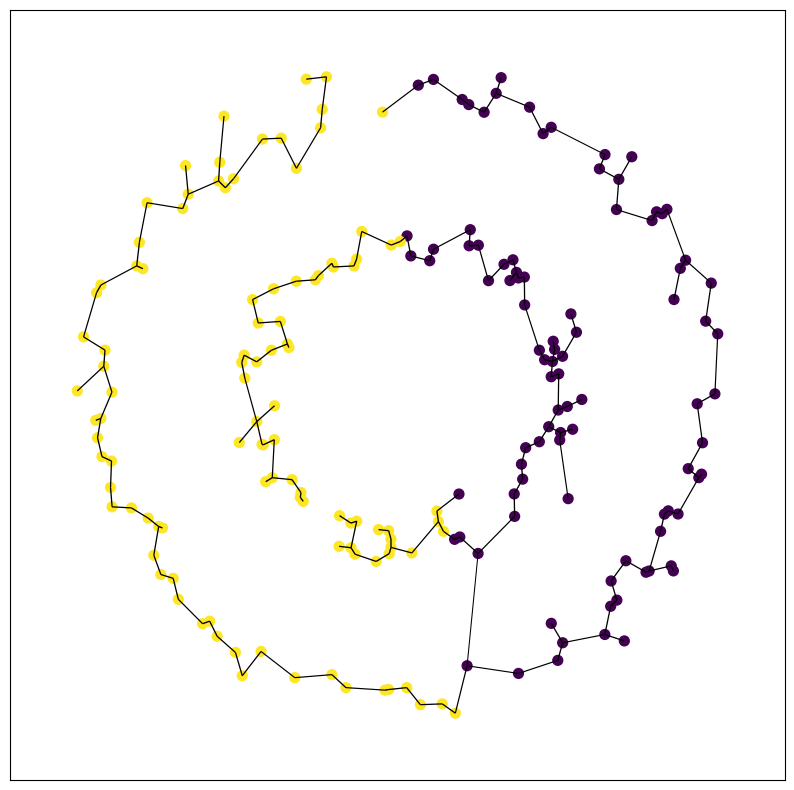

In [120]:
PCA_(setX, MST_G, cluster_labels_X_EM)

## spectral algorithm

In [121]:
spectral_clus = SpectralClustering(affinity='precomputed', n_clusters=2, random_state=42)

In [122]:
cluster_labels_X_spectral = spectral_clus.fit_predict(similar_matrix_X)

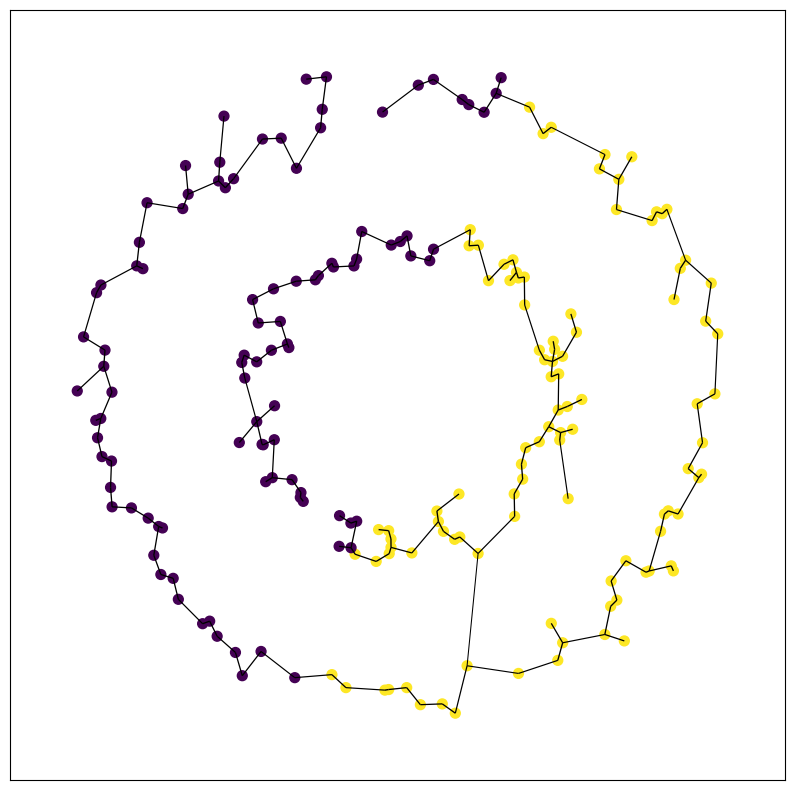

In [123]:
PCA_(setX, MST_G, cluster_labels_X_spectral)

## comparison clusters with RAND index

In [124]:
CLUSTERS_X = [cluster_labels_X_ward, cluster_labels_X_kmeans, cluster_labels_X_EM, cluster_labels_X_spectral]

def RAND_index(cluster1, cluster2):
    return f"RAND index = {adjusted_rand_score(cluster1, cluster2)}"


### ward & k-means

In [125]:
RAND_index(CLUSTERS_X[0], CLUSTERS_X[1])

'RAND index = 0.2239791857973676'

### ward & EM

In [126]:
RAND_index(CLUSTERS_X[0], CLUSTERS_X[2])

'RAND index = 0.18704323241722196'

### ward & spectral

In [127]:
RAND_index(CLUSTERS_X[0], CLUSTERS_X[3])

'RAND index = 0.5433623677559761'

### k-means & EM

In [128]:
RAND_index(CLUSTERS_X[1], CLUSTERS_X[2])

'RAND index = 0.8824420658265663'

### k-means & spectral

In [129]:
RAND_index(CLUSTERS_X[1], CLUSTERS_X[3])

'RAND index = 0.5433623677559761'

### EM & spectral

In [130]:
RAND_index(CLUSTERS_X[2], CLUSTERS_X[3])

'RAND index = 0.48530342476523775'

### conclusions

+ 

## Modular func

In [142]:
cluster_labels_X_ward_new = [1 if label == 2 else 0 for label in cluster_labels_X_ward.copy()]

FOR_MODULAR = [cluster_labels_X_ward_new, cluster_labels_X_kmeans, cluster_labels_X_EM, cluster_labels_X_spectral]

In [143]:
def Modular_for_clust(cluster):
    nodes_cluster1 = [i for i, label in enumerate(cluster) if label == 0]
    nodes_cluster2 = [i for i, label in enumerate(cluster) if label == 1]

    partition = [
        nodes_cluster1,
        nodes_cluster2
    ]

    Q = nx.community.modularity(MST_G, partition)

    return Q

In [145]:
for cluster in FOR_MODULAR:
    print(Modular_for_clust(cluster))

0.48626512544317724
0.48019702068744763
0.47335868544952486
0.48022578432290886


### conclutions

+

## general conclutions

+
